# Station Inventory distance scale checking script

This script is used to perform statistical checks on the station locations in the reconciled station metadata database against large catalog of seismic events with 'known' (i.e taken as 'ground truth') distances to stations.

## Setup of libraries and notebook

In [1]:
%matplotlib inline
#%load_ext line_profiler

In [2]:
import os
import sys
# Add root of passive-seismic repository to Python path
sys.path.append(os.path.realpath('..'))

from collections import defaultdict

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Customize matplotlib figure size for improve screen usage and resolution
plt.rcParams["figure.figsize"] = (10,10)

In [4]:
import obspy
# This is a bit dodgy since it assumes sperical earth...
from obspy.geodetics.base import locations2degrees

In [5]:
# Progress bar helper to indicate that slow tasks have not stalled
from tqdm.auto import tqdm

In [6]:
# Hardwired seed for repeatability
import random
random.seed(20190118)

In [7]:
# Use lightweight event catalog reader. TODO: Replace this with a shared, common event reader, e.g. see createEnsembleXML.py
from dataio.catalogcsv import CatalogCSV

## Configure file locations for input and output files

In [8]:
# Input for event catalog, whole folder read by CatalogCSV
event_src_folder = r'/g/data/ha3/am7399/temp'
# Input station inventory, generated by cleanup script engd2stxml.py
inventory_src_file = r'/g/data/ha3/am7399/dev/passive-seismic/inventory/INVENTORY_20190116T144005.csv'
# Path in which to save png plots of the distance correlation
graphic_save_path = os.path.join(event_src_folder, 'plots')
os.makedirs(graphic_save_path, exist_ok=True)

## Load the event catalog

In [9]:
# Load event catalog. Need to use dill rather than pickle, to cover more data types.
import dill as pkl
pkl_file = os.path.join(event_src_folder, "CAT.pkl")
if os.path.exists(pkl_file):
    with open(pkl_file, 'rb') as f:
        cat = pkl.load(f)
else:
    cat = CatalogCSV(event_src_folder)
    with open(pkl_file, 'wb') as f:
        pkl.dump(cat, f, pkl.HIGHEST_PROTOCOL)

## Load station inventory

In [10]:
inv = pd.read_csv(inventory_src_file, sep=',', keep_default_na=False,
                  parse_dates=['StationStart','StationEnd','ChannelStart','ChannelEnd'])
# Only using BHZ channels
inv = inv[inv['ChannelCode'] == 'BHZ']

## Process the event catalog against the station inventory

### Define a main processing function

This function loops through all the station codes in the catalog. Since most events do not have a network code, only a station code, we will gather all matching station codes from the station inventory to plot against the events.

For each station in the event catalog, we compute the distance of all matching stations from the inventory and index them against the station code, with subindex of the full network.station code, collecting computed distances against reported distances for all 'P' events.

For each station, we only gather up to MAX_EVENT_SAMPLES samples as this is plenty to perform a linear fit to the data. Note that when we extract the position of the stations from the inventory for a given event, we must consider the station and channel dates to make sure they contain the event date (+1 hour for the event to propagate to stations).

In [11]:
def processCatalog(cat, inv, num_stations=-1, distfunc=locations2degrees):
    '''Output has dictionary structure:
            {
             'StationCode':
                {
                 'NetworkCode.StationCode': 
                    {
                     'Distance': [...],           # list of values
                     'ComputedDistance': [...]    # list of values
                    } 
                } 
            }
    '''
    hour = np.timedelta64(1, 'h')
    #import pdb
    MAX_EVENT_SAMPLES = 100
    compute_dist = lambda x: distfunc(x.Latitude, x.Longitude, epicenter[0], epicenter[1])
    stations = [s for s in cat.station_dict.keys()]
    if num_stations > 0:
        stations = stations[0:num_stations]
    agg_result = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
    progress = tqdm(total=len(stations))
    # Precompute full names
    inv['FullCode'] = inv['NetworkCode'].map(str) + "." + inv['StationCode']
    for stn in stations:
        progress.update()
        # Only consider P waves
        station_events = cat.station_dict[stn]['P']
        if len(station_events) == 0:
            continue
        #pdb.set_trace()
        df_st = inv[inv['StationCode'] == stn]
        if df_st.empty:
            continue
        # Precompute some masks
        stst = df_st['StationStart']
        sten = df_st['StationEnd']
        chst = df_st['ChannelStart']
        chen = df_st['ChannelEnd']
        stst_na = stst.isna().values
        sten_na = sten.isna().values
        chst_na = chst.isna().values
        chen_na = chen.isna().values
        # Don't need to plot all events to detect distance error, a sampling of events will do.
        num_samples = min(MAX_EVENT_SAMPLES, len(station_events))
        for event_id, event_distance_deg in random.sample(station_events, num_samples):
            event = cat.event_dict[event_id]
            epicenter = event.preferred_origin.epicenter()
            event_date = np.datetime64(event.preferred_origin.utctime)
            event_window_end = event_date + hour
            station_mask = stst_na | ((stst.values < event_date) & (sten_na | (sten.values > event_window_end)))
            channel_mask = chst_na | ((chst.values < event_date) & (chen_na | (chen.values > event_window_end)))
            df_event = df_st[station_mask & channel_mask]
            if df_event.empty:
                continue
            computed_dist_deg = df_event.apply(compute_dist, axis=1)
            for idx, dist in computed_dist_deg.iteritems():
                full_code = df_event.loc[idx, "FullCode"]
                agg_result[stn][full_code]['Distance'].append(event_distance_deg)
                agg_result[stn][full_code]['ComputedDistance'].append(dist)
    progress.close()
    return agg_result

### Execute the main distance processing function. Will load cached pickled result if available.

In [12]:
do_profile = False
if do_profile:
    %lprun -f processCatalog agg_result=processCatalog(cat, inv, 100)
else:
    import dill as pkl
    pkl_file = os.path.join(event_src_folder, "distances.pkl")
    if os.path.exists(pkl_file):
        with open(pkl_file, 'rb') as f:
            agg_result = pkl.load(f)
    else:
        # Perform processing of distances
        agg_result = processCatalog(cat, inv)
        with open(pkl_file, 'wb') as f:
            pkl.dump(agg_result, f, pkl.HIGHEST_PROTOCOL)

## Plotting and analyses

For each station code, we generate an x-y scatter plot of event reported distance (ground truth) against computed distance. Where multiple networks match the station code, we overly the plots for each network in order to ascertain whether they refer to the same station or a geographically distinct station. Note: due to number of stations, the plotting loop is expensive, so is disabled by default in this notebook.

The results dictionary from the above _processCatalog()_ function is flattened to be indexed by NetworkCode.StationCode, and then for each we perform a simple least squares linear regression to determine the slope and y-intercept of the Distance vs ComputedDistance, as well as computing an RMS error and a count of the number of contributing seismic events. These are then used to filter the results, looking for outliers with poor correlation between expected and actual distance.

Once the filters are applied to detect candidate bad stations, the candidate list is written to file, and the corresponding distance plots for those stations are collected for review.

### Generate all distance plots (disabled by default)

In [13]:
def plotStationDistances(stn, stn_data, savepath=None):
    '''Plotting function for the data for a single station code as generated by function processCatalog().
    '''
    import itertools
    import os
    marker = itertools.cycle(('x', '1', '+', '2'))
    xval = [v['Distance'] for v in stn_data.values()]
    yval = [v['ComputedDistance'] for v in stn_data.values()]
    # Overlay plot for each network code
    [plt.plot(x, y, marker=next(marker), markersize=10, linestyle='', fillstyle=None) for x, y in zip(xval, yval)]
    plt.axis('equal')
    plt.title(stn, fontsize=16)
    plt.legend(stn_data.keys(), fontsize=14)
    plt.grid()
    plt.gca().tick_params(axis='both', labelsize=14)
    plt.xlabel('Distance (deg)', fontsize=14)
    plt.ylabel('Computed Distance (deg)', fontsize=14)    
    if savepath:
        plt.savefig(os.path.join(savepath, stn + ".png"), dpi=100)
        plt.close()
    else:
        plt.show()

In [14]:
# Dump images to files. Takes ~ 1 hour, so only run when condition set to True.
if False:
    [plotStationDistances(stn, stn_data, graphic_save_path) for stn, stn_data in agg_result.items()]

### Peform statistical analyses

In [15]:
# First, flatten the result dictionary to eliminate the top level redundant key.
stn_data = {k: v for stn, netstn in agg_result.items() for k, v in netstn.items()}

In [16]:
# For each network.station, compute a linear regression to the distance data points.
# Each regression will generate a 2D point (y-intercept, slope).
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
progress = tqdm(len(stn_data))
# Collect the results in a dict by network.station code. Each entry contains regression results, RMSE and event count.
lr_dict = {}
for k, v in stn_data.items():
    progress.update()
    lm = linear_model.LinearRegression()
    xx = np.array(v['Distance'])
    yy = np.array(v['ComputedDistance'])
    rmse = np.sqrt(mean_squared_error(xx, yy))
    event_count = len(xx)
    model = lm.fit(np.reshape(xx, (-1, 1)), np.reshape(yy, (-1, 1)))
    # Store as tuple of ('Intercept', 'Slope', 'RMSE', 'EventCount')
    lr_dict[k] = (*model.intercept_, *model.coef_.flatten(), rmse, event_count)
progress.close()

In [17]:
# Ingest the dict into a Pandas dataframe,, indexed by station identity
lr_df = pd.DataFrame.from_dict(lr_dict, orient='index', columns=['Intercept', 'Slope', 'RMSE', 'EventCount'])
lr_df.sort_index(inplace=True)

### Analyze the tabulated regression and error data to identify poor distance correlations

In [18]:
# Use seaborn for 2D distribution plots
import seaborn as sns

In [19]:
# Alias data series to friendlier names
slope = lr_df['Slope']
intercept = lr_df['Intercept']
rmse = lr_df['RMSE']
counts = lr_df['EventCount']

In [20]:
# Range of slope values (optimal is 1.0)
min(slope), max(slope)

(-1.762095762310528, 70.27001021851996)

In [21]:
# Range of intercept values (optimal is 0.0)
min(intercept), max(intercept)

(-1454.9578526118453, 180.43561936935737)

In [22]:
# Range of RMSE values (optimal is 0.0)
min(rmse), max(rmse)

(6.361189804238165e-06, 105.86555296961146)

In [23]:
# Range of count values (ignore bad fit when counts < 5)
min(counts), max(counts)

(1, 470)

#### USE HISTOGRAMS TO VIEW DISTRIBUTION OF THE COLLECTED STATISTICS

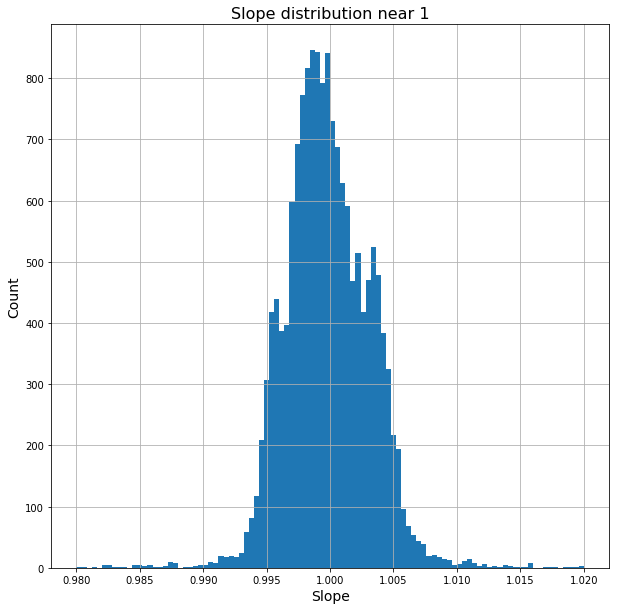

In [32]:
n, bins, patches = plt.hist(slope, 100, range=(0.98, 1.02))
plt.title('Slope distribution near 1', fontsize=16)
plt.xlabel('Slope', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid()

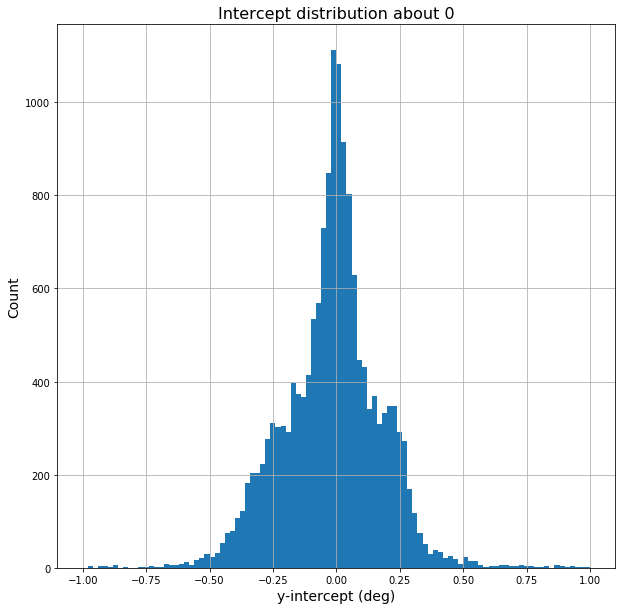

In [33]:
n, bins, patches = plt.hist(intercept, 100, range=(-1, 1))
plt.title('Intercept distribution about 0', fontsize=16)
plt.xlabel('y-intercept (deg)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid()

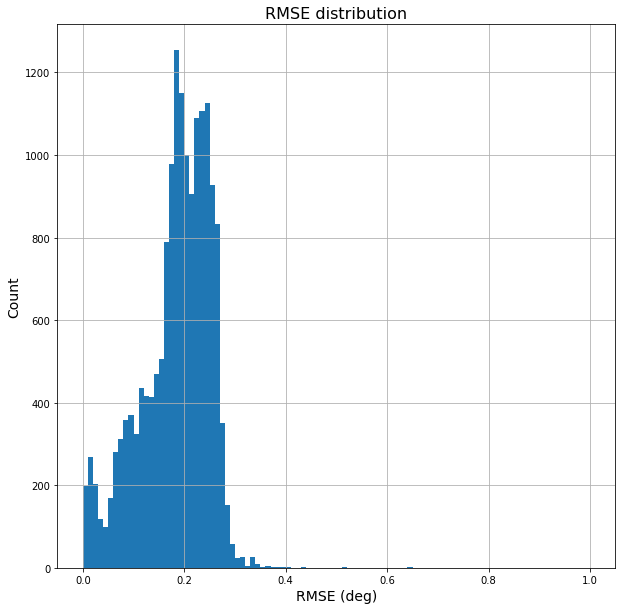

In [34]:
n, bins, patches = plt.hist(rmse, 100, range=(0, 1))
plt.title('RMSE distribution', fontsize=16)
plt.xlabel('RMSE (deg)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid()

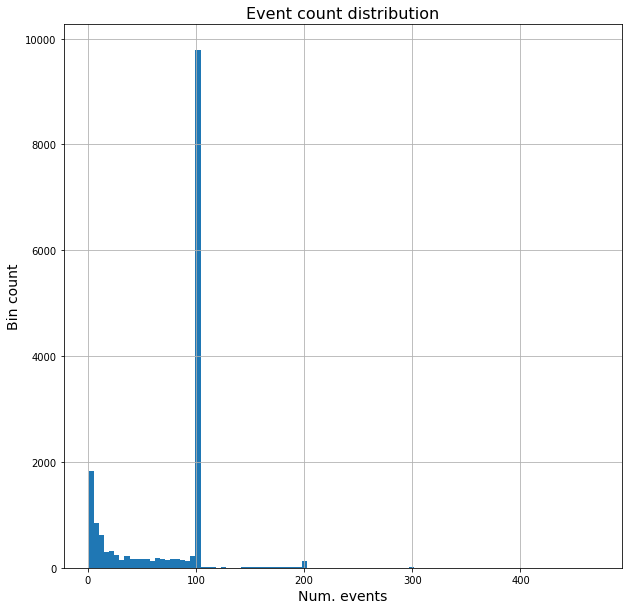

In [36]:
n, bins, patches = plt.hist(counts, 100)
plt.title('Event count distribution', fontsize=16)
plt.xlabel('Num. events', fontsize=14)
plt.ylabel('Bin count', fontsize=14)
plt.grid()

#### Create 2D KDE plot to visualize distribution of slope and intercept near optimal point

We mask the data to the vicinity of the optimal point so that the detail can be seen. The outliers are so far away that if we include them, we can't see any detail near the optimal point.

Text(0.5, 1.0, 'Distribution of near-optimal linear fits')

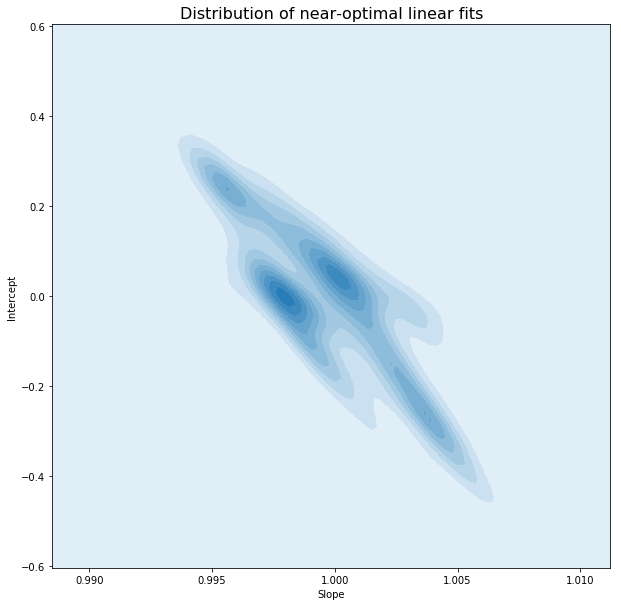

In [43]:
masked = ((slope>=0.99) & (slope<=1.01) & (intercept>=-0.5) & (intercept<=0.5))
sns.kdeplot(slope[masked], intercept[masked], shade=True, color='C0').set_title("Distribution of near-optimal linear fits", fontsize=16)

#### Repeat previous plot, but with a wider range of values and masked by low RMSE for an alternate view

Text(0.5, 1.0, 'Distribution of low RMSE linear fits')

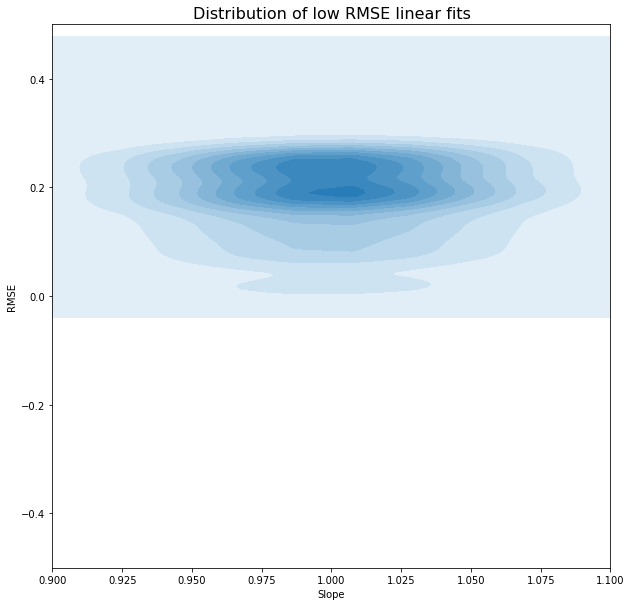

In [45]:
masked = (rmse <= 0.5)
p = sns.kdeplot(slope[masked], rmse[masked], shade=True, color='C0', gridsize=100)
p.set(xlim=(0.9, 1.1), ylim=(-0.5, 0.5))
p.set_title("Distribution of low RMSE linear fits", fontsize=16)

### Based on the above visualizations, a final composite mask is applied to identify BAD distance data

The code here self-documents the limits applied. A station whose distance data is considerd 'bad' must satisfy the following criteria:
* either slope or intercept must be outside reasonable range, AND
* RMSE must be outside reasonable range, AND
* the number of seismic events used for the statistics must be at least MIN_EVENTS

In [47]:
MIN_EVENTS = 5
slope_lims = (0.95, 1.05)
intercept_lims = (-1.0, 1.0)
rmse_lim = 0.5

s0 = (slope < slope_lims[0])
s1 = (slope > slope_lims[1])
i0 = (intercept < intercept_lims[0])
i1 = (intercept > intercept_lims[1])
ec_mask = (counts >= MIN_EVENTS)
rmse_mask = (rmse > rmse_lim)

# Display number of stations captured by each mask individually
print(s0.sum(), s1.sum(), i0.sum(), i1.sum(), ec_mask.sum(), rmse_mask.sum())

# Compute the aggregate mask for identifying 'bad' stations
outliers_mask = (s0 | s1 | i0 | i1) & ec_mask & rmse_mask

776 25 104 802 15206 53


In [48]:
# Filter the Pandas DataFrame to the bad stations and emit one line report
df_outliers = lr_df[outliers_mask]
bad_stn_codes = [s.split('.')[1] for s in df_outliers.index.values]
print(len(df_outliers), '/', len(lr_df), ' stations identified as bad')

43 / 16816  stations identified as bad


### Emit results to file in tabulated form, and collect the corresponding plots for review

In [49]:
BAD_STATIONS_FILE_NAME = "bad_distance_scale.txt"
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    with open(os.path.join(graphic_save_path, BAD_STATIONS_FILE_NAME), "w") as f:
        s = str(df_outliers)
        f.write(s)

In [50]:
import shutil
bad_plots_path = os.path.join(event_src_folder, 'bad_plots')
os.makedirs(bad_plots_path, exist_ok=True)
for bad_stn in bad_stn_codes:
    bad_stn_plotname = bad_stn + ".png"
    src_file = os.path.join(graphic_save_path, bad_stn_plotname)
    dst_file = os.path.join(bad_plots_path, bad_stn_plotname)
    shutil.copy2(src_file, dst_file)